
# Comparison of the different under-sampling algorithms


The following example attends to make a qualitative comparison between the
different under-sampling algorithms available in the imbalanced-learn package.




- ClusterCentroids: 
- RandomUnderSampler: 가장 나이브한 랜덤 셀렉팅 방법.
- NearMiss: 좀 휴리스틱한 방법임. 1, 2, 3 버전이 있는데 셋이 다 다름
    - NearMiss-1: 
    - NearMiss-2: 
    - NearMiss-3: 일단 얼추 보니까 3이 좋아보임

In [3]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (ClusterCentroids,
                                     RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection)
print(__doc__)

Automatically created module for IPython interactive environment


The following function will be used to create toy dataset. It using the
``make_classification`` from scikit-learn but fixing some parameters.



In [4]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

The following function will be used to plot the sample space after resampling
to illustrate the characteristic of an algorithm.



In [5]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

The following function will be used to plot the decision function of a
classifier given some data.



In [6]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

Prototype generation: under-sampling by generating new samples
##############################################################################



``ClusterCentroids`` under-samples by replacing the original samples by the
centroids of the cluster found.



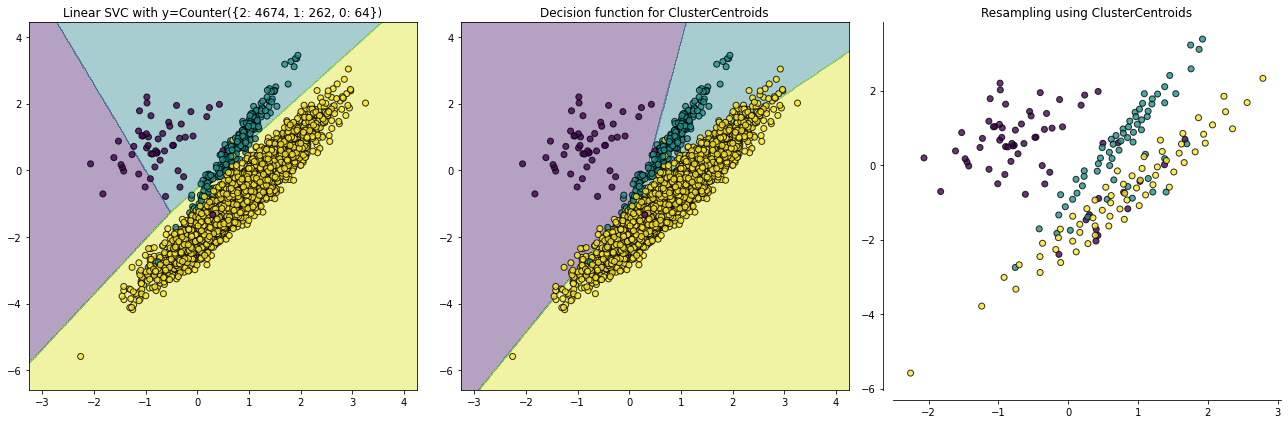

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = ClusterCentroids(random_state=0)
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
plot_resampling(X, y, sampler, ax3)
ax3.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

Prototype selection: under-sampling by selecting existing samples
##############################################################################



The algorithm performing prototype selection can be subdivided into two
groups: (i) the controlled under-sampling methods and (ii) the cleaning
under-sampling methods.



With the controlled under-sampling methods, the number of samples to be
selected can be specified. ``RandomUnderSampler`` is the most naive way of
performing such selection by randomly selecting a given number of samples by
the targetted class.



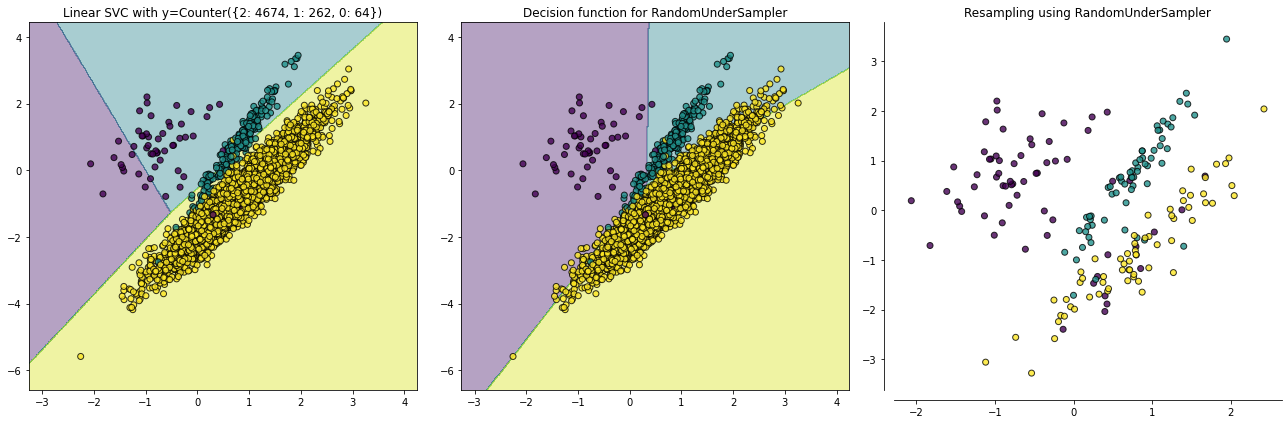

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = RandomUnderSampler(random_state=0)
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
plot_resampling(X, y, sampler, ax3)
ax3.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

``NearMiss`` algorithms implement some heuristic rules in order to select
samples. NearMiss-1 selects samples from the majority class for which the
average distance of the $k$` nearest samples of the minority class is
the smallest. NearMiss-2 selects the samples from the majority class for
which the average distance to the farthest samples of the negative class is
the smallest. NearMiss-3 is a 2-step algorithm: first, for each minority
sample, their :$m$ nearest-neighbors will be kept; then, the majority
samples selected are the on for which the average distance to the $k$
nearest neighbors is the largest.



C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number 

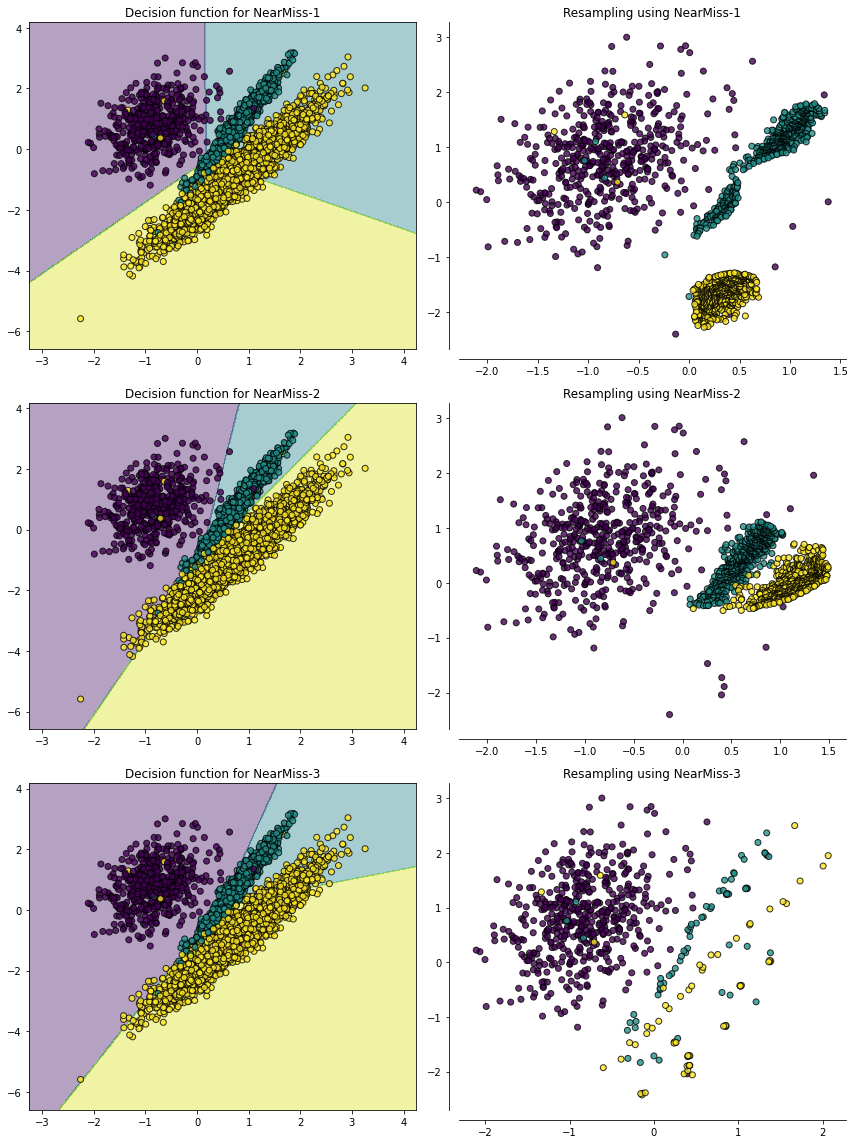

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,
                                                         figsize=(12, 16))
X, y = create_dataset(n_samples=5000, weights=(0.1, 0.2, 0.7), class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
for ax, sampler in zip(ax_arr, (NearMiss(version=1),
                                NearMiss(version=2),
                                NearMiss(version=3))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}-{}'.format(
        sampler.__class__.__name__, sampler.version))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}-{}'.format(
        sampler.__class__.__name__, sampler.version))
fig.tight_layout()

``EditedNearestNeighbours`` removes samples of the majority class for which
their class differ from the one of their nearest-neighbors. This sieve can be
repeated which is the principle of the
``RepeatedEditedNearestNeighbours``. ``AllKNN`` is slightly different from
the ``RepeatedEditedNearestNeighbours`` by changing the $k$ parameter
of the internal nearest neighors algorithm, increasing it at each iteration.



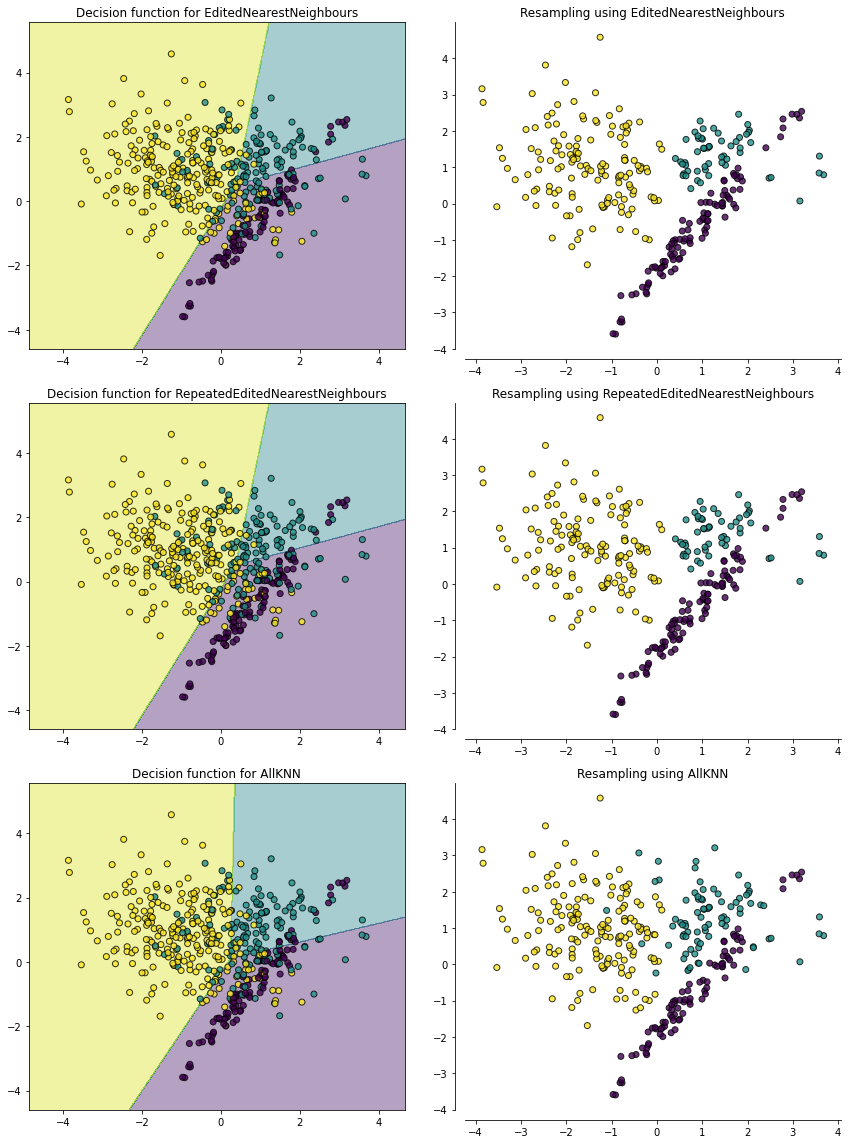

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,
                                                         figsize=(12, 16))
X, y = create_dataset(n_samples=500, weights=(0.2, 0.3, 0.5), class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
for ax, sampler in zip(ax_arr, (
        EditedNearestNeighbours(),
        RepeatedEditedNearestNeighbours(),
        AllKNN(allow_minority=True))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

``CondensedNearestNeighbour`` makes use of a 1-NN to iteratively decide if a
sample should be kept in a dataset or not. The issue is that
``CondensedNearestNeighbour`` is sensitive to noise by preserving the noisy
samples. ``OneSidedSelection`` also used the 1-NN and use ``TomekLinks`` to
remove the samples considered noisy. The ``NeighbourhoodCleaningRule`` use a
``EditedNearestNeighbours`` to remove some sample. Additionally, they use a 3
nearest-neighbors to remove samples which do not agree with this rule.



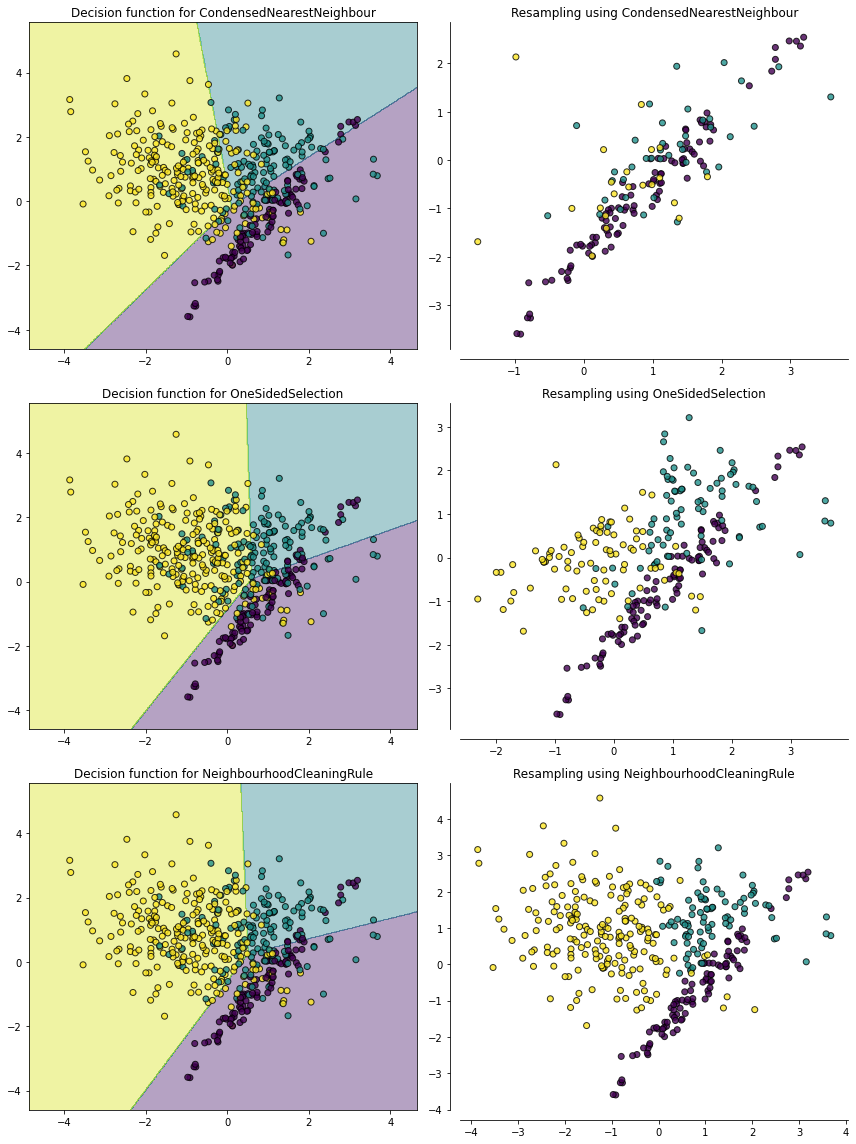

In [21]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,
                                                         figsize=(12, 16))
X, y = create_dataset(n_samples=500, weights=(0.2, 0.3, 0.5), class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
for ax, sampler in zip(ax_arr, (
        CondensedNearestNeighbour(random_state=0),
        OneSidedSelection(random_state=0),
        NeighbourhoodCleaningRule())):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

``InstanceHardnessThreshold`` uses the prediction of classifier to exclude
samples. All samples which are classified with a low probability will be
removed.



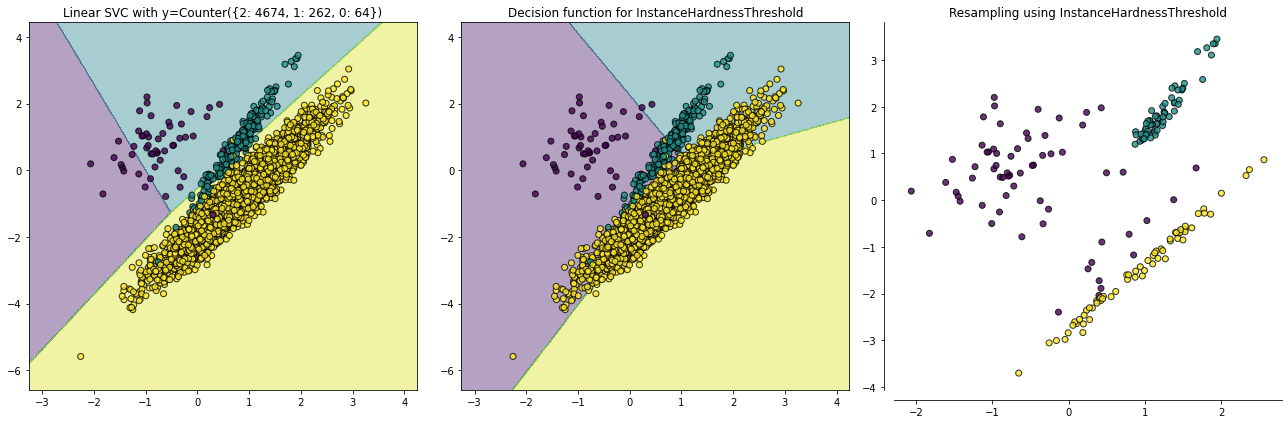

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = InstanceHardnessThreshold(
    random_state=0, estimator=LogisticRegression(solver='lbfgs',
                                                 multi_class='auto'))
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
plot_resampling(X, y, sampler, ax3)
ax3.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

plt.show()